In [1]:
# run with PyTorchEnv Kernel

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchvision.utils as vutils
from t_sneV2 import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import copy
import numpy as np
import pickle
import time

%matplotlib notebook

In [2]:
class MnistNet(nn.Module):
    def __init__(self):
        super(MnistNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
    def forward_latent(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        return x

In [3]:
class FashionMnistNet(nn.Module):
    def __init__(self):
        super(FashionMnistNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1)
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(4*4*64, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
#         x = F.relu(self.conv3(x))
#         x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, 4*4*64)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)
    
    def forward_latent(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
#         x = F.relu(self.conv3(x))
#         x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, 4*4*64)
        
        x = F.relu(self.fc1(x))
        
        return x

In [4]:
def train(log_interval, tsne_interval, model, device,
          train_loader, test_loader, tsne_loader, optimizer, epochs, tsne):
    
    model.train()
    
    yzs    = []
    kls    = []
    losses = []
    for epoch in range(1, epochs + 1):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            if batch_idx % tsne_interval == 0:
                kl_t, yz_t = get_tsne(model, device, tsne_loader, tsne, is_pca=True, to_normalize=False)
                yzs.append(yz_t)
                kls.append(kl_t)
                losses.append(loss.item())
            
    yzs    = np.array(yzs)
    kls    = np.array(kls)
    losses = np.array(losses)
    return yzs, kls, losses

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
def get_tsne(model, device, tsne_loader, tsne, is_pca, to_normalize):
    
    x = next(iter(tsne_loader))

    z = model.forward_latent(x[0]).detach().numpy()
    
    if is_pca:
        pca = PCA(n_components=n_components)
        if to_normalize:
            z = StandardScaler().fit_transform(z)
        z = pca.fit_transform(z)
    
    yz = tsne.fit_transform(z)
    kl = tsne.kl_divergence_original_
    
    return kl, yz

In [5]:
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [6]:
# Training settings
batch_size=64
test_batch_size=10000

epochs=2
lr=0.01
momentum=0.5
seed=1
log_interval=10
tsne_interval=10

is_pca = True
to_normalize = False
n_components = 50

torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class SubsetDataset(Dataset):
    """
    A dataset that wraps another dataset, returning a subset from it.
    """
    def __init__(self, source_dataset: Dataset, subset_len, offset=0):
        """
        Create a SubsetDataset from another dataset.
        :param source_dataset: The dataset to take samples from.
        :param subset_len: The total number of sample in the subset.
        :param offset: The offset index to start taking samples from.
        """
        if offset + subset_len > len(source_dataset):
            raise ValueError("Not enough samples in source dataset")

        self.source_dataset = source_dataset
        self.subset_len = subset_len
        self.offset = offset

    def __getitem__(self, index):
        if self.offset + index >= self.offset + self.subset_len:
            raise IndexError()
        else:
            return self.source_dataset[self.offset+index]


    def __len__(self):
        return self.subset_len


In [8]:
mydatasets = {'mnist'   : datasets.MNIST,
            'fashion-mnist' : datasets.FashionMNIST}

In [9]:
train_dataset = mydatasets['mnist']('./data/MNIST', train=True, download=True,
                   transform=transforms.Compose([transforms.ToTensor(),
                                                 transforms.Normalize((0.1307,), (0.3081,))]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = mydatasets['mnist']('./data/MNIST', train=False, download=True,
                    transform=transforms.Compose([transforms.ToTensor(),
                                                  transforms.Normalize((0.1307,), (0.3081,))]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

fraction_from_testset = 0.5
tsne_dataset = SubsetDataset(test_dataset, int(fraction_from_testset*len(test_dataset)), 0)
tsne_loader = torch.utils.data.DataLoader(tsne_dataset, batch_size=len(tsne_dataset), shuffle=False)

100.1%

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


113.5%

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw


100.4%

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw


180.4%

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw
Processing...
Done!


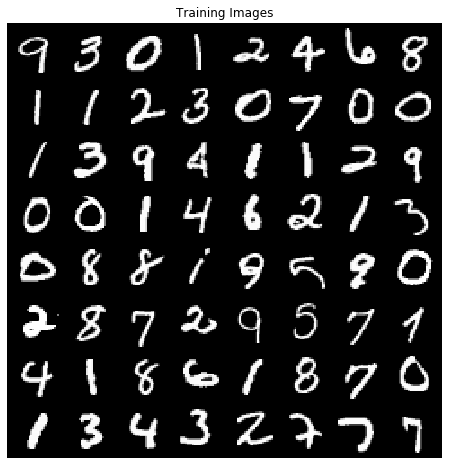

In [10]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [11]:
modes  = ['reg', 'last', 'prior', 'both']
alphas = [0.1,0.3,0.5, 0.7, 0.9]

res = {}

for mode in modes:
    
    if mode in ['reg', 'last']:
        model = MnistNet().to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        tsne = TSNE(random_state=seed, verbose=0, mode=mode, init='pca')

        yzs, kls, losses = train(log_interval=log_interval, tsne_interval=tsne_interval,
                                 model=model, device=device, train_loader=train_loader,
                                 test_loader=test_loader, tsne_loader=tsne_loader, optimizer=optimizer, epochs=epochs,
                                 tsne=tsne)
        res[mode] = {
            'kl'   : kls,
            'embd' : yzs,
            'loss' : losses
        }
        
        print("Collected {} loss values".format(len(res[mode]['loss'])))
        
        test(model, device, test_loader)
        
        res_fname = 'tsne-mnist' + time.strftime("%m_%d_%Y-%H_%M")
        save_obj(res, res_fname)
        
    elif mode in ['prior', 'both']:
        for alpha in alphas:
            model = MnistNet().to(device)
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
            tsne = TSNE(random_state=seed, verbose=0, mode=mode, alpha=alpha, init='pca')

            yzs, kls, losses = train(log_interval=log_interval, tsne_interval=tsne_interval,
                                 model=model, device=device, train_loader=train_loader,
                                 test_loader=test_loader, tsne_loader=tsne_loader, optimizer=optimizer, epochs=epochs,
                                 tsne=tsne)
            
            test(model, device, test_loader)
            
            res[mode+'_'+str(alpha)] = {
                'kl'   : kls,
                'embd' : yzs,
                'loss' : losses
            }
    
            res_fname = 'tsne-mnist' + '_' + time.strftime("%m_%d_%Y-%H_%M")
            save_obj(res, res_fname)
    
            

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.333251
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.198164
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.081283
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.914554
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.683882
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.263658
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.902051
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.724368
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.827248
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.358880
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.436460
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.508518
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.417254
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.379447
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.282218
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.470871
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.400600
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.395530
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.294735
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.378646
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.080418
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.194837
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.066653
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.103334
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.086187
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.046664
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.025429
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.024996
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.051611
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.135681
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.142491
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.135435
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.021559
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.080374
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.040633
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.126690
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.122468
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.051769
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.091684
Train Epoch: 2 [58240/60000 (97%)]	Loss: 0.062309


Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.077316
Train Epoch: 2 [31360/60000 (52%)]	Loss: 0.039962
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.087986
Train Epoch: 2 [32640/60000 (54%)]	Loss: 0.129475
Train Epoch: 2 [33280/60000 (55%)]	Loss: 0.115789
Train Epoch: 2 [33920/60000 (57%)]	Loss: 0.051487
Train Epoch: 2 [34560/60000 (58%)]	Loss: 0.075088
Train Epoch: 2 [35200/60000 (59%)]	Loss: 0.075187
Train Epoch: 2 [35840/60000 (60%)]	Loss: 0.089647
Train Epoch: 2 [36480/60000 (61%)]	Loss: 0.087137
Train Epoch: 2 [37120/60000 (62%)]	Loss: 0.026764
Train Epoch: 2 [37760/60000 (63%)]	Loss: 0.094103
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.086220
Train Epoch: 2 [39040/60000 (65%)]	Loss: 0.092180
Train Epoch: 2 [39680/60000 (66%)]	Loss: 0.056730
Train Epoch: 2 [40320/60000 (67%)]	Loss: 0.042019
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.110949
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.089252
Train Epoch: 2 [42240/60000 (70%)]	Loss: 0.099611
Train Epoch: 2 [42880/60000 (71%)]	Loss: 0.333682


Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.066211
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.182555
Train Epoch: 2 [16640/60000 (28%)]	Loss: 0.194620
Train Epoch: 2 [17280/60000 (29%)]	Loss: 0.066366
Train Epoch: 2 [17920/60000 (30%)]	Loss: 0.080757
Train Epoch: 2 [18560/60000 (31%)]	Loss: 0.157315
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.115934
Train Epoch: 2 [19840/60000 (33%)]	Loss: 0.117003
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.105999
Train Epoch: 2 [21120/60000 (35%)]	Loss: 0.437067
Train Epoch: 2 [21760/60000 (36%)]	Loss: 0.157838
Train Epoch: 2 [22400/60000 (37%)]	Loss: 0.095762
Train Epoch: 2 [23040/60000 (38%)]	Loss: 0.063028
Train Epoch: 2 [23680/60000 (39%)]	Loss: 0.077755
Train Epoch: 2 [24320/60000 (41%)]	Loss: 0.032261
Train Epoch: 2 [24960/60000 (42%)]	Loss: 0.061856
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.064705
Train Epoch: 2 [26240/60000 (44%)]	Loss: 0.075429
Train Epoch: 2 [26880/60000 (45%)]	Loss: 0.349333
Train Epoch: 2 [27520/60000 (46%)]	Loss: 0.017818


Train Epoch: 2 [0/60000 (0%)]	Loss: 0.078562
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.052091
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.046742
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.028760
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.117276
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.053275
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.044359
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.134628
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.027750
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.025416
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.088468
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.090894
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.143635
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.198898
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.088153
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.155972
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.021750
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.078879
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.041128
Train Epoch: 2 [12160/60000 (20%)]	Loss: 0.089965
Train Epoch: 2 [12800/60000 (

Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.201304
Train Epoch: 1 [45440/60000 (76%)]	Loss: 0.094470
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.103344
Train Epoch: 1 [46720/60000 (78%)]	Loss: 0.096448
Train Epoch: 1 [47360/60000 (79%)]	Loss: 0.059296
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.085067
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.124502
Train Epoch: 1 [49280/60000 (82%)]	Loss: 0.169137
Train Epoch: 1 [49920/60000 (83%)]	Loss: 0.104819
Train Epoch: 1 [50560/60000 (84%)]	Loss: 0.076176
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.129074
Train Epoch: 1 [51840/60000 (86%)]	Loss: 0.058354
Train Epoch: 1 [52480/60000 (87%)]	Loss: 0.153442
Train Epoch: 1 [53120/60000 (88%)]	Loss: 0.084931
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.237962
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.075692
Train Epoch: 1 [55040/60000 (92%)]	Loss: 0.095354
Train Epoch: 1 [55680/60000 (93%)]	Loss: 0.132280
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.106016
Train Epoch: 1 [56960/60000 (95%)]	Loss: 0.110235


Train Epoch: 1 [29440/60000 (49%)]	Loss: 0.193150
Train Epoch: 1 [30080/60000 (50%)]	Loss: 0.107783
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.172476
Train Epoch: 1 [31360/60000 (52%)]	Loss: 0.209916
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.057587
Train Epoch: 1 [32640/60000 (54%)]	Loss: 0.061546
Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.069475
Train Epoch: 1 [33920/60000 (57%)]	Loss: 0.207079
Train Epoch: 1 [34560/60000 (58%)]	Loss: 0.119565
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.100409
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.193668
Train Epoch: 1 [36480/60000 (61%)]	Loss: 0.093368
Train Epoch: 1 [37120/60000 (62%)]	Loss: 0.184914
Train Epoch: 1 [37760/60000 (63%)]	Loss: 0.075542
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.126554
Train Epoch: 1 [39040/60000 (65%)]	Loss: 0.234400
Train Epoch: 1 [39680/60000 (66%)]	Loss: 0.114687
Train Epoch: 1 [40320/60000 (67%)]	Loss: 0.101895
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.061902
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.113494


Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.261377
Train Epoch: 1 [14720/60000 (25%)]	Loss: 0.188736
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.336442
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.162412
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.099903
Train Epoch: 1 [17280/60000 (29%)]	Loss: 0.256381
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.229903
Train Epoch: 1 [18560/60000 (31%)]	Loss: 0.208310
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.241302
Train Epoch: 1 [19840/60000 (33%)]	Loss: 0.384491
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.272223
Train Epoch: 1 [21120/60000 (35%)]	Loss: 0.268402
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.209369
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.509254
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.203380
Train Epoch: 1 [23680/60000 (39%)]	Loss: 0.106495
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.131310
Train Epoch: 1 [24960/60000 (42%)]	Loss: 0.142813
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.182337
Train Epoch: 1 [26240/60000 (44%)]	Loss: 0.179723


Train Epoch: 2 [59520/60000 (99%)]	Loss: 0.052691

Test set: Average loss: 0.0605, Accuracy: 9823/10000 (98%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.324567
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.236219
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.111824
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.965693
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.630524
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.421504
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.971820
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.811928
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.586129
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.589320
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.522521
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.381472
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.466257
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.354861
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.424025
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.421501
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.408908
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.316617
Train Epoch: 1 [11

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.167277
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.196411
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.052004
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.079942
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.017608
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.043613
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.041474
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.128751
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.033861
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.112325
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.107715
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.028030
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.036580
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.149319
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.081234
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.033641
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.036020
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.029587
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.029841
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.074355


Train Epoch: 2 [28800/60000 (48%)]	Loss: 0.049082
Train Epoch: 2 [29440/60000 (49%)]	Loss: 0.174736
Train Epoch: 2 [30080/60000 (50%)]	Loss: 0.047482
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.072392
Train Epoch: 2 [31360/60000 (52%)]	Loss: 0.058473
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.072795
Train Epoch: 2 [32640/60000 (54%)]	Loss: 0.138843
Train Epoch: 2 [33280/60000 (55%)]	Loss: 0.021788
Train Epoch: 2 [33920/60000 (57%)]	Loss: 0.057078
Train Epoch: 2 [34560/60000 (58%)]	Loss: 0.038347
Train Epoch: 2 [35200/60000 (59%)]	Loss: 0.028126
Train Epoch: 2 [35840/60000 (60%)]	Loss: 0.021492
Train Epoch: 2 [36480/60000 (61%)]	Loss: 0.212867
Train Epoch: 2 [37120/60000 (62%)]	Loss: 0.056207
Train Epoch: 2 [37760/60000 (63%)]	Loss: 0.081742
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.073117
Train Epoch: 2 [39040/60000 (65%)]	Loss: 0.044789
Train Epoch: 2 [39680/60000 (66%)]	Loss: 0.021220
Train Epoch: 2 [40320/60000 (67%)]	Loss: 0.047230
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.176590


Train Epoch: 2 [13440/60000 (22%)]	Loss: 0.077410
Train Epoch: 2 [14080/60000 (23%)]	Loss: 0.049936
Train Epoch: 2 [14720/60000 (25%)]	Loss: 0.075856
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.058090
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.051873
Train Epoch: 2 [16640/60000 (28%)]	Loss: 0.085256
Train Epoch: 2 [17280/60000 (29%)]	Loss: 0.020566
Train Epoch: 2 [17920/60000 (30%)]	Loss: 0.079692
Train Epoch: 2 [18560/60000 (31%)]	Loss: 0.087842
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.028335
Train Epoch: 2 [19840/60000 (33%)]	Loss: 0.060932
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.009094
Train Epoch: 2 [21120/60000 (35%)]	Loss: 0.049597
Train Epoch: 2 [21760/60000 (36%)]	Loss: 0.100133
Train Epoch: 2 [22400/60000 (37%)]	Loss: 0.013335
Train Epoch: 2 [23040/60000 (38%)]	Loss: 0.085734
Train Epoch: 2 [23680/60000 (39%)]	Loss: 0.219293
Train Epoch: 2 [24320/60000 (41%)]	Loss: 0.071851
Train Epoch: 2 [24960/60000 (42%)]	Loss: 0.202465
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.062796


Train Epoch: 1 [58240/60000 (97%)]	Loss: 0.078720
Train Epoch: 1 [58880/60000 (98%)]	Loss: 0.075273
Train Epoch: 1 [59520/60000 (99%)]	Loss: 0.129290
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.093162
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.070669
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.035103
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.054965
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.082550
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.149544
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.069750
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.182596
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.053914
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.088159
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.057627
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.025403
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.166205
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.076328
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.249602
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.131830
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.079496
Train Epoch: 2 [10880/60000 (

Train Epoch: 1 [42880/60000 (71%)]	Loss: 0.115205
Train Epoch: 1 [43520/60000 (72%)]	Loss: 0.188829
Train Epoch: 1 [44160/60000 (74%)]	Loss: 0.157847
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.060693
Train Epoch: 1 [45440/60000 (76%)]	Loss: 0.143231
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.059653
Train Epoch: 1 [46720/60000 (78%)]	Loss: 0.196282
Train Epoch: 1 [47360/60000 (79%)]	Loss: 0.052389
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.207428
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.083091
Train Epoch: 1 [49280/60000 (82%)]	Loss: 0.074611
Train Epoch: 1 [49920/60000 (83%)]	Loss: 0.201622
Train Epoch: 1 [50560/60000 (84%)]	Loss: 0.166575
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.116160
Train Epoch: 1 [51840/60000 (86%)]	Loss: 0.159761
Train Epoch: 1 [52480/60000 (87%)]	Loss: 0.045644
Train Epoch: 1 [53120/60000 (88%)]	Loss: 0.140021
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.223580
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.085173
Train Epoch: 1 [55040/60000 (92%)]	Loss: 0.090588


In [13]:
res = load_obj('tsne-mnist_11_10_2019-09_54')
res.keys()

dict_keys(['reg', 'last', 'prior_0.1', 'prior_0.3', 'prior_0.5', 'prior_0.7', 'prior_0.9', 'both_0.1', 'both_0.3', 'both_0.5', 'both_0.7', 'both_0.9'])

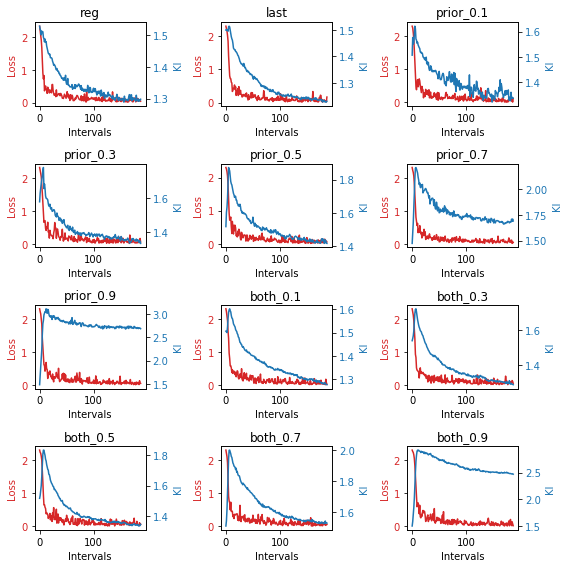

In [14]:
fig,axes = plt.subplots(4,3, figsize=(8,8))

bluecolor = 'tab:blue'

for i, (k1, v1) in enumerate(res.items()):
#     print(i, k1)
    kl = v1['kl']
    loss = v1['loss']
    color = 'tab:red'
    axes[int(i/3), int(i%3)].set_xlabel('Intervals')
    axes[int(i/3), int(i%3)].set_ylabel('Loss', color=color)
    axes[int(i/3), int(i%3)].plot(loss, color=color)
    axes[int(i/3), int(i%3)].tick_params(axis='y', labelcolor=color)
    
    axes[int(i/3), int(i%3)].set_title(k1)
    ax_t = axes[int(i/3), int(i%3)].twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax_t.set_ylabel('Kl', color=color)  # we already handled the x-label with ax1
    ax_t.plot(kl, color=color)
    ax_t.tick_params(axis='y', labelcolor=color)
    
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()